# Tmax Subset

A notebook to subset Tmax daily for the 13000 GHS urban areas to identify dates >40c, consecuritve days >40 c etc.

### Depdencies

In [26]:
import pandas as pd
import numpy as np
import xarray as xr
from random import random
from itertools import groupby
from operator import itemgetter
import geopandas as gpd

### Search for num days > 40

In [2]:
def csv_to_xr(file_in, time_dim, space_dim):
    
    """ Function reads in a csv w/ GHS-UCDB IDs and temp, isolates the temp
    and returns a xarray data array with dims set to city ids and dates
    
    Args:
        file_in = file name and path
        time_dim = name for time dim as a str ... use date :-)
        space_dim = col name for GHS-UCDB IDs as an str (ID_HDC_G0)
    """
    
    df = pd.read_csv(file_in) # read the file in as a df
    print(df.shape)
    df_id = df[space_dim] # get IDs
    df_temp = df.iloc[:,3:] # get only temp columns
    df_temp.index = df_id # set index values
    df_temp_drop = df_temp.dropna() # Drop cities w/ no temp record 
    print(len(df_temp_drop))
    
    temp_np = df_temp_drop.to_numpy() # turn temp cols into an np array
    
    # make xr Data Array w/ data as temp and dims as spece (e.g. id)
    temp_xr_da = xr.DataArray(temp_np, coords=[df_temp_drop.index, df_temp_drop.columns], dims=[space_dim, time_dim])
    
    return temp_xr_da

In [3]:
file_in = '/Users/cascade/Desktop/GHS-Tmax-DAILY_1983.csv'

xr1983 = csv_to_xr(file_in, 'date', 'ID_HDC_G0')

(13135, 368)
13067


In [4]:
xr1983

<xarray.DataArray (ID_HDC_G0: 13067, date: 365)>
array([[-43.921947, -33.71345 , -33.054974, ..., -12.416152, -13.232986,
        -15.403823],
       [ -4.804248,  -3.914425,  -7.533999, ...,  -5.186461, -10.945722,
        -16.29516 ],
       [-23.904118, -17.422953, -13.182008, ..., -12.788978, -11.337886,
        -10.00939 ],
       ...,
       [ 16.028023,  17.73603 ,  20.493294, ...,  14.559421,  15.160739,
         15.184024],
       [ 16.420553,  17.87142 ,  22.519674, ...,  15.680964,  16.169733,
         16.039179],
       [ 16.6943  ,  17.559229,  21.480919, ...,  14.446052,  15.235602,
         14.005591]])
Coordinates:
  * ID_HDC_G0  (ID_HDC_G0) int64 5782 3316 5645 3185 ... 1116 1114 1161 1169
  * date       (date) object '1983.01.01' '1983.01.02' ... '1983.12.31'

In [20]:
def temp_numday(xarray, Tthresh):
    """ Function returns the number of days within a year where Tmax > Tthresh for each city.
    
    Args: 
        xarray = an xarray object with dims = (space, times)
        Tthresh = int of temp threshold
    """
    
    ## NOTE FOR SOME REASON out.ID_HDC_G0 cannot be fed a string ... note sure why so be careful with col names
    out = xarray.where(xarray > Tthresh, drop = True)
    id_list = []
    event_tot = []
    df_out = pd.DataFrame()
    
    for index, loc in enumerate(out.ID_HDC_G0):
        id_list.append(out.ID_HDC_G0.values[index])
        event_tot.append(len(out.sel(ID_HDC_G0 = loc).dropna(dim = 'date').date.values))
    
    df_out['ID_HDC_G0'] = id_list
    df_out['event_tot'] = event_tot
    
    return df_out

In [23]:
events = temp_numday(xr1983, 40)

### Plot it

Text(0.5, 1.0, 'For all cities with Tmax >40, how many days in 1983 were >40C?')

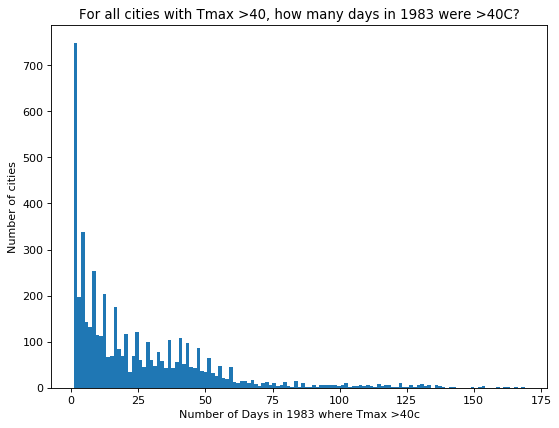

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
%matplotlib inline

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
y = range(1,125)
plt.hist(events['event_tot'], bins = 125)
plt.xlabel('Number of Days in 1983 where Tmax >40c')
plt.ylabel('Number of cities')
plt.title('For all cities with Tmax >40, how many days in 1983 were >40C?')

In [49]:
# MAP BACK TO POLYGONS AND LOOK AT IT 
SHP_DIR = '/Users/cascade/Github/UrbanHeat/data/raw/ghs-ucdb/'
shp_fn = 'GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp'
shps = gpd.read_file(SHP_DIR+shp_fn)

In [50]:
df_ghs = gpd.GeoDataFrame()
df_ghs['geometry'] = shps.geometry
df_ghs['ID_HDC_G0'] = shps.ID_HDC_G0

In [51]:
df_merge = df_ghs.merge(events, on='ID_HDC_G0', how = 'inner') #<<<<----- NEED TO FIX THIS

In [54]:
# Write it out
DATA_INTERIM = '/Users/cascade/Github/UrbanHeat/data/interim/'
fn_out = 'GHS-TmaxDaily-events.shp'
df_merge.to_file(DATA_INTERIM+fn_out)

# Old Code

In [ ]:
# This will return the ID and Date where Tmax is greater than 40 as a dict, but will not return actual tempatures 

Tmax = np.random.randint(20, high=50, size=(3,10)) # Make a 3x10 random list
print(Tmax)
results = np.where(Tmax > 40) # find the index and rows
coords = list(zip(results[0], results[1])) # zip the i and js into tuples

b = [(k, list(list(zip(*g))[1])) for k, g in groupby(coords, itemgetter(0))] # group by rows

print(b)
dict_out = dict(b) # turn into a dict, where keys are city ids and values are dates
dict_out


In [ ]:
for key, value in dict_out.items():
    print(key, value)

In [ ]:
np.where(Tmax > 40, Tmax, Tmax*0) 

In [ ]:
np.where(Tmax > 40) 

In [ ]:
np.argwhere(Tmax>1)

In [ ]:
def temp_search(array):
    results = np.where(array > 40) # find the index and rows
    coords = list(zip(results[0], results[1])) # zip the i and js into tuples
    b = [(k, list(list(zip(*g))[1])) for k, g in groupby(coords, itemgetter(0))] # group by rows
    dict_out = dict(b) # turn into a dict, where keys are city ids and values are dates

    return dict_out

In [ ]:
file_in = '/Users/cascade/Desktop/GHS-Tmax-DAILY_1983.csv'

df = pd.read_csv(file_in)

In [ ]:
df.head()

In [ ]:
df_sub = df.iloc[:,3:]

In [ ]:
df_sub_drop = df.dropna(how='all')

In [ ]:
df_sub.head()
arr = df_sub.to_numpy()

In [ ]:
arr.shape

In [ ]:
np.unique(arr)

In [ ]:
tmax_search = temp_search(arr)

In [ ]:
# Make some fake data
Tmax = np.random.randint(20, high=50, size=(3,10))
locs = ['001', '002', '003']
times = pd.date_range('2000-01-01', periods=10)

In [ ]:
foo = xr.DataArray(Tmax, coords=[locs, times], dims=['space', 'times'])

In [ ]:
foo

In [ ]:
out = foo.where(foo > 40, drop = True)
out

In [ ]:
for loc in out.space:
    print(len(out.sel(space = loc).dropna(dim = 'times').times.values))

In [ ]:
for x in out.space.values:
    print(x)

In [ ]:
out.space.values[0]